In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

### 종목별 일봉 데이터와 코스피 지수 데이터와 결합   
앞에서 저장한 종목 리스트, 코스닥 종목별 주가 데이터와 지수 데이터를 읽습니다. 인덱스(날짜) 의 최소값과 최대값을 확인해 봅니다.

In [2]:
price_data = pd.read_pickle('stock_data_from_fdr.pkl')
kosdaq_index = pd.read_pickle('kosdaq_index.pkl')
kosdaq_list = pd.read_pickle('kosdaq_list.pkl')

print(price_data.index.min(), price_data.index.max())
print(kosdaq_index.index.min(), kosdaq_index.index.max())

2021-01-04 00:00:00 2022-03-31 00:00:00
2021-01-04 00:00:00 2022-05-06 00:00:00


<br> 나중에 검정할 가설 중 하나가 "주가가 상승할 확률이 높은 종목은 마켓이 안 좋을 때(즉 지표가 빠질 때) 수익율이 좋았다" 입니다. 이 가설을 검증하기 위해 두 데이타셋을 병합합니다. 두 데이터를 종목별 날짜별로 병합을 해야 '종목 수익율'과 '코스닥 지수 수익율'을 비교할 수 있습니다.

price_data 를 기준으로 kosdaq_index 데이터의 지수 수익율을 추가합니다. price_data 에 날짜를 Index 로 left merge 를 하면 주가지수 정보를 추가할 수 있습니다.

In [3]:
merged = price_data.merge(kosdaq_index['kosdaq_return'], left_index=True, right_index=True, how='left')
merged.head()

,open,high,low,close,volume,change,code,name,kosdaq_return
date,,,,,,,,,
2021-01-04,2185,2320,2135,2260,588133,0.044,060310,3S,NaN
2021-01-04,8220,8270,7960,8000,300316,-0.026,054620,APS홀딩스,NaN
2021-01-04,25100,25600,24800,25500,415285,0.026,265520,AP시스템,NaN
2021-01-04,7960,8470,7790,8330,424730,0.052,211270,AP위성,NaN
2021-01-04,0,0,0,4075,0,0.000,032790,BNGT,NaN


<br>가설 검정을 위해 미리 컬럼을 생성합니다. 코스닥 지수 수익율이 1 보다 적을 때, 종목의 수익율이 1 보다 크면 1, 아니면 0 을 생성합니다. 그 값을 win_market 이라는 새로운 컬럼에 저장합니다. 아래오와 같이 np.where 구문을 사용했는데요. 

```python
stock_return['win_market'] = np.where((c1&c2), 1, 0)
```
이 메소드는 np.where(조건, 조건이 참일 때 값, 조건이 거짓일 때 값)와 같이 처리를 합니다. 

In [63]:
return_all = pd.DataFrame()

for code in kosdaq_list['code']:  
    
    stock_return = merged[merged['code']==code].sort_index()
    stock_return['return'] = stock_return['close']/stock_return['close'].shift(1) # 종목별 전일 종가 대비 당일 종가 수익율
    c1 = (stock_return['kosdaq_return'] < 1) # 수익율 1 보다 작음. 당일 종가가 전일 종가보다 낮음 (코스닥 지표)
    c2 = (stock_return['return'] > 1) # 수익율 1 보다 큼. 당일 종가가 전일 종가보다 큼 (개별 종목)
    stock_return['win_market'] = np.where((c1&c2), 1, 0) # C1 과 C2 조건을 동시에 만족하면 1, 아니면 0
    return_all = pd.concat([return_all, stock_return], axis=0) 
    
return_all.to_pickle('return_all.pkl')       

<br> 값이 잘 들어갔는 지 head 메소드로 첫 번째 행 5 개를 출력해 봅니다.

In [4]:
return_all = pd.read_pickle('return_all.pkl')  
return_all.head()

,open,high,low,close,volume,change,code,name,kosdaq_return,return,win_market
date,,,,,,,,,,,
2021-01-04,2185,2320,2135,2260,588133,0.044,060310,3S,NaN,NaN,0
2021-01-05,2270,2285,2200,2250,410263,-0.004,060310,3S,1.008,0.996,0
2021-01-06,2225,2310,2215,2290,570349,0.018,060310,3S,0.996,1.018,1
2021-01-07,2290,2340,2240,2290,519777,0.000,060310,3S,1.008,1.000,0
2021-01-08,2300,2315,2225,2245,462568,-0.020,060310,3S,0.999,0.980,0


가설 검정 시 자세히 다루겠지만, win_market 의 비율과 종목별 수익율과의 관계를 간단하게 조사하겠습니다. 이번에 scatter plot 를 함 그려보겠습니다. Scatter plot 에는 x 축의 값과 y 축의 값을 인수로 넣어주면 됩니다. 그래프를 보니 두 값 사이에 상관성이 높아 보입니다. 

Text(0, 0.5, 'Avg. Return')

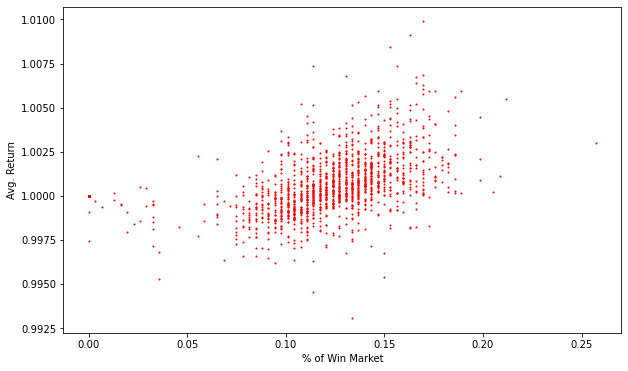

In [5]:
plt.figure(figsize=(10,6))
x = return_all.groupby('code')['win_market'].mean() # 종목별 win_market의 비율
y = return_all.groupby('code')['return'].mean() # 종목별 평균 수익율 
plt.scatter(x = x , y= y, s=1, color='red')
plt.xlabel('% of Win Market')
plt.ylabel('Avg. Return')